In [1]:
!pip install tensorflowjs==2.8.0 --quiet

In [2]:
import tensorflow as tf
import tensorflowjs as tfjs

print(f"Current TensorFlow version: {tf.__version__}")
print(f"Current TensorFlow JS version: {tfjs.__version__}")
print(f"Keras version (via TensorFlow): {tf.keras.__version__}")

Current TensorFlow version: 2.1.0
Current TensorFlow JS version: 2.8.0
Keras version (via TensorFlow): 2.2.4-tf


# import libraries

In [3]:
# Import libraries
import json
import math
import os
import shutil # For file operations
from glob import glob 
from tqdm import tqdm
from PIL import Image
import cv2 # image processing
import numpy as np # linear algebra
import pandas as pd # data processing
import matplotlib.pyplot as plt # data visualization
import random
from collections import defaultdict

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.callbacks import EarlyStopping

# Define source paths for the datasets

In [4]:
# Set random seeds for reproducibility
random.seed(42)
np.random.seed(42)

# Create working directory structure
output_base_dir = '/kaggle/working/balanced_xray_dataset'
os.makedirs(output_base_dir, exist_ok=True)

# Create temporary collection directories
temp_collections = {
    'tuberculosis': os.path.join(output_base_dir, 'temp_tuberculosis'),
    'normal': os.path.join(output_base_dir, 'temp_normal'), 
    'pneumonia': os.path.join(output_base_dir, 'temp_pneumonia')
}

for path in temp_collections.values():
    os.makedirs(path, exist_ok=True)

print("✅ Libraries imported and directories created!")
print(f"📁 Working directory: {output_base_dir}")

✅ Libraries imported and directories created!
📁 Working directory: /kaggle/working/balanced_xray_dataset


# Collect images from dataset

In [5]:
# Define all dataset paths and their structures
dataset_configs = {
    'tbx11k': {
        'path': '/kaggle/input/tbx11k-simplified/tbx11k-simplified',
        'type': 'csv_based',
        'csv_file': 'data.csv',
        'images_folder': 'images',
        'mapping': {'tb': 'tuberculosis', 'no_tb': 'normal'}
    },
    'shenzhen': {
        'path': '/kaggle/input/tuberculosis-chest-xrays-shenzhen',
        'type': 'csv_based', 
        'csv_file': 'shenzhen_metadata.csv',
        'images_folder': 'images/images',
        'mapping': {'normal': 'normal', 'other': 'tuberculosis'}  # everything not normal is TB
    },
    'tb_chest_db': {
        'path': '/kaggle/input/tuberculosis-tb-chest-xray-dataset/TB_Chest_Radiography_Database',
        'type': 'folder_based',
        'folders': {
            'Normal': 'normal',
            'Tuberculosis': 'tuberculosis'
        }
    },
    'covid_pneumonia_tb': {
        'path': '/kaggle/input/chest-xray-pneumoniacovid19tuberculosis',
        'type': 'split_folder_based',
        'splits': ['train', 'val', 'test'],
        'folders': {
            'NORMAL': 'normal',
            'PNEUMONIA': 'pneumonia', 
            'TURBERCULOSIS': 'tuberculosis'
        }
    },
    'chest_xray_pneumonia': {
        'path': '/kaggle/input/chest-xray-pneumonia/chest_xray',
        'type': 'split_folder_based',
        'splits': ['train', 'val', 'test'],
        'folders': {
            'NORMAL': 'normal',
            'PNEUMONIA': 'pneumonia'
        }
    }
}

def collect_images_from_datasets():
    """Collect all images from all datasets and organize by class"""
    
    collected_images = defaultdict(list)
    
    for dataset_name, config in dataset_configs.items():
        print(f"\n📥 Processing {dataset_name}...")
        
        if config['type'] == 'csv_based':
            # Handle CSV-based datasets (TBX11K, Shenzhen)
            csv_path = os.path.join(config['path'], config['csv_file'])
            images_path = os.path.join(config['path'], config['images_folder'])
            
            if os.path.exists(csv_path):
                df = pd.read_csv(csv_path)
                
                if dataset_name == 'tbx11k':
                    # TBX11K specific handling
                    for _, row in df.iterrows():
                        target = row['target'].lower()
                        if target in config['mapping']:
                            class_name = config['mapping'][target]
                            img_path = os.path.join(images_path, row['fname'])
                            if os.path.exists(img_path):
                                collected_images[class_name].append((img_path, dataset_name))
                
                elif dataset_name == 'shenzhen':
                    # Shenzhen specific handling
                    for _, row in df.iterrows():
                        findings = row['findings'].lower().strip()
                        if findings == 'normal':
                            class_name = 'normal'
                        else:
                            class_name = 'tuberculosis'  # everything else is TB
                        
                        img_path = os.path.join(images_path, row['study_id'])
                        if os.path.exists(img_path):
                            collected_images[class_name].append((img_path, dataset_name))
        
        elif config['type'] == 'folder_based':
            # Handle simple folder-based datasets (TB Chest DB)
            for folder_name, class_name in config['folders'].items():
                folder_path = os.path.join(config['path'], folder_name)
                if os.path.exists(folder_path):
                    for img_file in os.listdir(folder_path):
                        if img_file.lower().endswith(('.png', '.jpg', '.jpeg')):
                            img_path = os.path.join(folder_path, img_file)
                            collected_images[class_name].append((img_path, dataset_name))
        
        elif config['type'] == 'split_folder_based':
            # Handle pre-split datasets (COVID+Pneumonia+TB, Chest X-ray Pneumonia)
            for split in config['splits']:
                split_path = os.path.join(config['path'], split)
                if os.path.exists(split_path):
                    for folder_name, class_name in config['folders'].items():
                        folder_path = os.path.join(split_path, folder_name)
                        if os.path.exists(folder_path):
                            for img_file in os.listdir(folder_path):
                                if img_file.lower().endswith(('.png', '.jpg', '.jpeg')):
                                    img_path = os.path.join(folder_path, img_file)
                                    collected_images[class_name].append((img_path, f"{dataset_name}_{split}"))
        
        # Print progress for this dataset
        dataset_counts = defaultdict(int)
        for class_name, images in collected_images.items():
            dataset_counts[class_name] += len([img for img in images if img[1].startswith(dataset_name)])
        
        for class_name, count in dataset_counts.items():
            if count > 0:
                print(f"  {class_name}: {count} images")
    
    return collected_images

# Collect all images
print("🔍 Scanning all datasets for images...")
all_collected_images = collect_images_from_datasets()

# Print final collection summary
print(f"\n📊 Total Images Collected:")
for class_name, images in all_collected_images.items():
    print(f"  {class_name.title()}: {len(images)} images")
    
    # Show distribution by dataset
    dataset_dist = defaultdict(int)
    for _, dataset in images:
        dataset_dist[dataset] += 1
    
    for dataset, count in sorted(dataset_dist.items()):
        print(f"    └─ {dataset}: {count}")

print(f"\n✅ All datasets scanned and catalogued!")

🔍 Scanning all datasets for images...

📥 Processing tbx11k...
  normal: 7600 images
  tuberculosis: 1211 images

📥 Processing shenzhen...
  normal: 326 images
  tuberculosis: 336 images

📥 Processing tb_chest_db...
  normal: 3500 images
  tuberculosis: 700 images

📥 Processing covid_pneumonia_tb...
  normal: 1583 images
  tuberculosis: 703 images
  pneumonia: 4273 images

📥 Processing chest_xray_pneumonia...
  normal: 1583 images
  pneumonia: 4273 images

📊 Total Images Collected:
  Normal: 14592 images
    └─ chest_xray_pneumonia_test: 234
    └─ chest_xray_pneumonia_train: 1341
    └─ chest_xray_pneumonia_val: 8
    └─ covid_pneumonia_tb_test: 234
    └─ covid_pneumonia_tb_train: 1341
    └─ covid_pneumonia_tb_val: 8
    └─ shenzhen: 326
    └─ tb_chest_db: 3500
    └─ tbx11k: 7600
  Tuberculosis: 2950 images
    └─ covid_pneumonia_tb_test: 41
    └─ covid_pneumonia_tb_train: 650
    └─ covid_pneumonia_tb_val: 12
    └─ shenzhen: 336
    └─ tb_chest_db: 700
    └─ tbx11k: 1211
  Pneu

# CREATE BINARY DATASETS

In [6]:
def create_balanced_binary_datasets():
    """
    Create two properly balanced datasets with a shared normal folder:
    1. TB Model: ALL TB + ALL Normal images (using shared normal folder)
    2. Pneumonia Model: ALL Pneumonia + ALL Normal images (using shared normal folder)
    
    This approach creates one normal dataset that both models can reference,
    making it more memory efficient and consistent.
    """
    # Access image paths
    normal_images = all_collected_images.get('normal', [])
    tb_images = all_collected_images.get('tuberculosis', [])
    pneumonia_images = all_collected_images.get('pneumonia', [])

    print(f"\n📊 Available Images:")
    print(f"  Normal: {len(normal_images)}")
    print(f"  Tuberculosis: {len(tb_images)}")
    print(f"  Pneumonia: {len(pneumonia_images)}")
    
    # Debug: Check the structure of the first few items
    print(f"\n🔍 Data Structure Check:")
    if normal_images:
        print(f"  Normal sample: {type(normal_images[0])} - {normal_images[0]}")
    if tb_images:
        print(f"  TB sample: {type(tb_images[0])} - {tb_images[0]}")
    if pneumonia_images:
        print(f"  Pneumonia sample: {type(pneumonia_images[0])} - {pneumonia_images[0]}")

    # Helper function to extract file path from tuple or return as-is if string
    def extract_path(item):
        if isinstance(item, tuple):
            # Assuming the path is the first element of the tuple
            return item[0]
        elif isinstance(item, str):
            return item
        else:
            raise ValueError(f"Unexpected item type: {type(item)} - {item}")

    # Convert all items to paths
    normal_paths = [extract_path(item) for item in normal_images]
    tb_paths = [extract_path(item) for item in tb_images]
    pneumonia_paths = [extract_path(item) for item in pneumonia_images]

    print(f"\n📂 Extracted Paths:")
    print(f"  Normal paths: {len(normal_paths)}")
    print(f"  TB paths: {len(tb_paths)}")
    print(f"  Pneumonia paths: {len(pneumonia_paths)}")

    # Output dirs
    shared_normal_dir = '/kaggle/working/shared_normal_dataset'
    tb_dataset_dir = '/kaggle/working/tb_balanced_dataset'
    pneumonia_dataset_dir = '/kaggle/working/pneumonia_balanced_dataset'

    # Create folder structure for shared normal dataset
    for split in ['train', 'val', 'test']:
        os.makedirs(os.path.join(shared_normal_dir, split, 'Normal'), exist_ok=True)

    # Create folder structure for disease-specific datasets (only Disease folders)
    for base_dir in [tb_dataset_dir, pneumonia_dataset_dir]:
        for split in ['train', 'val', 'test']:
            os.makedirs(os.path.join(base_dir, split, 'Disease'), exist_ok=True)
            # Create symbolic links to shared normal folder
            normal_link = os.path.join(base_dir, split, 'Normal')
            shared_normal_split = os.path.join(shared_normal_dir, split, 'Normal')
            if not os.path.exists(normal_link):
                os.symlink(shared_normal_split, normal_link)

    # Helper to split data
    def split_images(image_list):
        total = len(image_list)
        train_size = int(total * 0.70)
        val_size = int(total * 0.15)
        train = image_list[:train_size]
        val = image_list[train_size:train_size + val_size]
        test = image_list[train_size + val_size:]
        return train, val, test

    # =============== CREATE SHARED NORMAL DATASET ===============
    print("\n🔄 Creating Shared Normal Dataset...")
    random.shuffle(normal_paths)
    
    # Use ALL normal images
    n_train, n_val, n_test = split_images(normal_paths)
    
    normal_counts = defaultdict(int)
    
    # Copy normal dataset files to shared location
    print("  Copying Normal dataset files to shared location...")
    for split, normal_list in zip(['train', 'val', 'test'], [n_train, n_val, n_test]):
        for img_path in tqdm(normal_list, desc=f"Normal {split}"):
            if os.path.exists(img_path):
                dest = os.path.join(shared_normal_dir, split, 'Normal', os.path.basename(img_path))
                shutil.copy2(img_path, dest)
                normal_counts[split] += 1
            else:
                print(f"Warning: File not found - {img_path}")

    # =============== TB DATASET ===============
    print("\n🦠 Creating TB Balanced Dataset...")
    random.shuffle(tb_paths)

    # Use ALL TB images
    tb_train, tb_val, tb_test = split_images(tb_paths)

    tb_counts = defaultdict(int)
    
    # Copy TB dataset files (only disease images, normal images are symlinked)
    print("  Copying TB disease files...")
    for split, disease_list in zip(['train', 'val', 'test'], [tb_train, tb_val, tb_test]):
        for img_path in tqdm(disease_list, desc=f"TB {split} Disease"):
            if os.path.exists(img_path):
                dest = os.path.join(tb_dataset_dir, split, 'Disease', os.path.basename(img_path))
                shutil.copy2(img_path, dest)
                tb_counts[split] += 1
            else:
                print(f"Warning: File not found - {img_path}")

    # ============ PNEUMONIA DATASET ============
    print("\n🫁 Creating Pneumonia Balanced Dataset...")
    random.shuffle(pneumonia_paths)

    # Use ALL pneumonia images
    pn_train, pn_val, pn_test = split_images(pneumonia_paths)

    pneumonia_counts = defaultdict(int)
    
    # Copy Pneumonia dataset files (only disease images, normal images are symlinked)
    print("  Copying Pneumonia disease files...")
    for split, disease_list in zip(['train', 'val', 'test'], [pn_train, pn_val, pn_test]):
        for img_path in tqdm(disease_list, desc=f"Pneumonia {split} Disease"):
            if os.path.exists(img_path):
                dest = os.path.join(pneumonia_dataset_dir, split, 'Disease', os.path.basename(img_path))
                shutil.copy2(img_path, dest)
                pneumonia_counts[split] += 1
            else:
                print(f"Warning: File not found - {img_path}")

    # =========== SUMMARY ===========
    print("\n📊 FINAL BALANCED DATASETS SUMMARY")
    print("="*60)
    
    print("\n🔄 Shared Normal Dataset:")
    normal_total = 0
    for split in ['train', 'val', 'test']:
        count = normal_counts[split]
        normal_total += count
        print(f"  {split:5}: Normal={count:4}")
    print(f"  {'TOTAL':5}: {normal_total:4} images")
    
    print("\n🦠 TB Binary Dataset:")
    tb_total = 0
    for split in ['train', 'val', 'test']:
        n = normal_counts[split]  # Same normal count for all
        d = tb_counts[split]
        total = n + d
        tb_total += total
        print(f"  {split:5}: Normal={n:4} (shared), TB={d:4}, Total={total:4}")
    print(f"  {'TOTAL':5}: {tb_total:4} images")

    print("\n🫁 Pneumonia Binary Dataset:")
    pn_total = 0
    for split in ['train', 'val', 'test']:
        n = normal_counts[split]  # Same normal count for all
        d = pneumonia_counts[split]
        total = n + d
        pn_total += total
        print(f"  {split:5}: Normal={n:4} (shared), Pneumonia={d:4}, Total={total:4}")
    print(f"  {'TOTAL':5}: {pn_total:4} images")

    print(f"\n✅ Datasets successfully balanced and created with shared normal folder!")
    print(f"📁 Shared Normal Dataset: {shared_normal_dir}")
    print(f"📁 TB Dataset: {tb_dataset_dir} (with symlinks to shared normal)")
    print(f"📁 Pneumonia Dataset: {pneumonia_dataset_dir} (with symlinks to shared normal)")
    print(f"\n💡 Both TB and Pneumonia datasets now use the same normal images via symbolic links,")
    print(f"    saving disk space and ensuring consistency across models!")
    
    return shared_normal_dir, tb_dataset_dir, pneumonia_dataset_dir, normal_counts, tb_counts, pneumonia_counts

# Run it
random.seed(42)
shared_normal_dir, tb_dataset_dir, pneumonia_dataset_dir, normal_stats, tb_stats, pneumonia_stats = create_balanced_binary_datasets()


📊 Available Images:
  Normal: 14592
  Tuberculosis: 2950
  Pneumonia: 8546

🔍 Data Structure Check:
  Normal sample: <class 'tuple'> - ('/kaggle/input/tbx11k-simplified/tbx11k-simplified/images/h0001.png', 'tbx11k')
  TB sample: <class 'tuple'> - ('/kaggle/input/tbx11k-simplified/tbx11k-simplified/images/tb0005.png', 'tbx11k')
  Pneumonia sample: <class 'tuple'> - ('/kaggle/input/chest-xray-pneumoniacovid19tuberculosis/train/PNEUMONIA/person1180_virus_2010.jpeg', 'covid_pneumonia_tb_train')


Normal train:   0%|          | 7/10214 [00:00<02:34, 66.05it/s]


📂 Extracted Paths:
  Normal paths: 14592
  TB paths: 2950
  Pneumonia paths: 8546

🔄 Creating Shared Normal Dataset...
  Copying Normal dataset files to shared location...


Normal val:  88%|████████▊ | 1923/2188 [00:21<00:02, 102.19it/s]

In [ ]:
IMAGE_SIZE = 224

def build_binary_model(model_name="binary_model"):
    """
    Build a focused binary classification model
    - Uses sigmoid for clear Normal vs Disease distinction
    - More focused learning than multi-label
    """
    base_vgg16 = VGG16(
        weights='imagenet',
        include_top=False,
        input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)
    )
    
    # Fine-tune last few layers for better performance
    for layer in base_vgg16.layers[:-4]:
        layer.trainable = False
    
    model = Sequential([
        base_vgg16,
        GlobalAveragePooling2D(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(1, activation='sigmoid') 
    ], name=model_name)
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
        loss='binary_crossentropy',
        metrics=['accuracy', Precision(), Recall()]
    )

    
    return model

# Test model creation
print("🏗️ Testing model architecture...")
test_model = build_binary_model("test_binary_model")
test_model.summary()
print("✅ Binary model architecture ready!")

In [ ]:
BATCH_SIZE = 32

def create_data_generators(dataset_dir, model_name):
    """Create data generators for a binary dataset"""
    
    # Data augmentation for training
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=15,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        fill_mode='nearest'
    )
    
    # No augmentation for validation and test
    val_test_datagen = ImageDataGenerator(rescale=1./255)
    
    # Create generators
    train_generator = train_datagen.flow_from_directory(
        os.path.join(dataset_dir, 'train'),
        target_size=(IMAGE_SIZE, IMAGE_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='binary',
        classes=['Normal', 'Disease'],  # Explicit order: 0=Normal, 1=Disease
        shuffle=True
    )
    
    val_generator = val_test_datagen.flow_from_directory(
        os.path.join(dataset_dir, 'val'),
        target_size=(IMAGE_SIZE, IMAGE_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='binary',
        classes=['Normal', 'Disease'],
        shuffle=False
    )
    
    test_generator = val_test_datagen.flow_from_directory(
        os.path.join(dataset_dir, 'test'),
        target_size=(IMAGE_SIZE, IMAGE_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='binary',
        classes=['Normal', 'Disease'],
        shuffle=False
    )
    
    print(f"\n📊 {model_name} Data Generators:")
    print(f"  Train samples: {train_generator.samples}")
    print(f"  Val samples: {val_generator.samples}")
    print(f"  Test samples: {test_generator.samples}")
    print(f"  Class indices: {train_generator.class_indices}")
    
    return train_generator, val_generator, test_generator

# Create generators for both models (but don't run training yet)
print("🔄 Setting up data generators...")
print("\n" + "="*50)
print("TB MODEL DATA GENERATORS")
print("="*50)
tb_train_gen, tb_val_gen, tb_test_gen = create_data_generators(tb_dataset_dir, "TB Model")

print("\n" + "="*50)
print("PNEUMONIA MODEL DATA GENERATORS")  
print("="*50)
pneumonia_train_gen, pneumonia_val_gen, pneumonia_test_gen = create_data_generators(pneumonia_dataset_dir, "Pneumonia Model")

print("\n✅ All data generators ready!")

In [9]:
EPOCHS=40
print("🦠 TRAINING TUBERCULOSIS BINARY MODEL")
print("="*60)

# Build TB model
tb_model = build_binary_model("tuberculosis_binary_model")

# Early stopping
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

# Train TB model
print("🚀 Starting TB model training...")
tb_history = tb_model.fit(
    tb_train_gen,
    epochs=EPOCHS,
    validation_data=tb_val_gen,
    callbacks=[early_stop],
    verbose=1
)

# Evaluate TB model
print("\n📊 Evaluating TB model on test set...")
tb_test_results = tb_model.evaluate(tb_test_gen, verbose=1)
tb_test_loss, tb_test_acc, tb_test_prec, tb_test_rec = tb_test_results

print(f"\n🦠 TB Model Final Results:")
print(f"  Test Loss: {tb_test_loss:.4f}")
print(f"  Test Accuracy: {tb_test_acc:.4f}")
print(f"  Test Precision: {tb_test_prec:.4f}")
print(f"  Test Recall: {tb_test_rec:.4f}")
print(f"  F1-Score: {2 * (tb_test_prec * tb_test_rec) / (tb_test_prec + tb_test_rec):.4f}")

print("\n✅ TB model training completed!")

🦠 TRAINING TUBERCULOSIS BINARY MODEL
🚀 Starting TB model training...
Train for 342 steps, validate for 81 steps
Epoch 1/40
342/342 [==============================] - 327s 956ms/step - loss: 0.2504 - accuracy: 0.9113 - precision_1: 0.8109 - recall_1: 0.4638 - val_loss: 0.1265 - val_accuracy: 0.9557 - val_precision_1: 0.8866 - val_recall_1: 0.8361
Epoch 2/40
342/342 [==============================] - 314s 917ms/step - loss: 0.1384 - accuracy: 0.9516 - precision_1: 0.8677 - recall_1: 0.7658 - val_loss: 0.1038 - val_accuracy: 0.9650 - val_precision_1: 0.9211 - val_recall_1: 0.8599
Epoch 3/40
342/342 [==============================] - 307s 897ms/step - loss: 0.1109 - accuracy: 0.9611 - precision_1: 0.8966 - recall_1: 0.8109 - val_loss: 0.0897 - val_accuracy: 0.9705 - val_precision_1: 0.9078 - val_recall_1: 0.9121
Epoch 4/40
342/342 [==============================] - 307s 897ms/step - loss: 0.1001 - accuracy: 0.9651 - precision_1: 0.9009 - recall_1: 0.8388 - val_loss: 0.0805 - val_accuracy: 

In [10]:
print("🫁 TRAINING PNEUMONIA BINARY MODEL")
print("="*60)

# Build Pneumonia model
pneumonia_model = build_binary_model("pneumonia_binary_model")

# Early stopping (reuse same settings)
early_stop_pneumonia = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

# Train Pneumonia model
print("🚀 Starting Pneumonia model training...")
pneumonia_history = pneumonia_model.fit(
    pneumonia_train_gen,
    epochs=EPOCHS,
    validation_data=pneumonia_val_gen,
    callbacks=[early_stop_pneumonia],
    verbose=1
)

# Evaluate Pneumonia model
print("\n📊 Evaluating Pneumonia model on test set...")
pneumonia_test_results = pneumonia_model.evaluate(pneumonia_test_gen, verbose=1)
pneumonia_test_loss, pneumonia_test_acc, pneumonia_test_prec, pneumonia_test_rec = pneumonia_test_results

print(f"\n🫁 Pneumonia Model Final Results:")
print(f"  Test Loss: {pneumonia_test_loss:.4f}")
print(f"  Test Accuracy: {pneumonia_test_acc:.4f}")
print(f"  Test Precision: {pneumonia_test_prec:.4f}")
print(f"  Test Recall: {pneumonia_test_rec:.4f}")
print(f"  F1-Score: {2 * (pneumonia_test_prec * pneumonia_test_rec) / (pneumonia_test_prec + pneumonia_test_rec):.4f}")

print("\n✅ Pneumonia model training completed!")

🫁 TRAINING PNEUMONIA BINARY MODEL
🚀 Starting Pneumonia model training...
Train for 416 steps, validate for 104 steps
Epoch 1/40
416/416 [==============================] - 325s 782ms/step - loss: 0.1503 - accuracy: 0.9367 - precision_2: 0.9098 - recall_2: 0.8684 - val_loss: 0.0792 - val_accuracy: 0.9723 - val_precision_2: 0.9738 - val_recall_2: 0.9472
Epoch 2/40
416/416 [==============================] - 318s 765ms/step - loss: 0.0712 - accuracy: 0.9756 - precision_2: 0.9591 - recall_2: 0.9571 - val_loss: 0.1954 - val_accuracy: 0.9369 - val_precision_2: 0.9969 - val_recall_2: 0.8238
Epoch 3/40
416/416 [==============================] - 327s 786ms/step - loss: 0.0558 - accuracy: 0.9799 - precision_2: 0.9663 - recall_2: 0.9643 - val_loss: 0.0966 - val_accuracy: 0.9615 - val_precision_2: 0.9906 - val_recall_2: 0.8996
Epoch 4/40
416/416 [==============================] - 329s 790ms/step - loss: 0.0455 - accuracy: 0.9841 - precision_2: 0.9746 - recall_2: 0.9708 - val_loss: 0.0441 - val_accur

📊 COMPARING BOTH MODELS

📋 Model Comparison:
             Model  Accuracy  Precision  Recall  F1-Score
0         TB Model    0.9857     0.9548  0.9570    0.9559
1  Pneumonia Model    0.9883     0.9880  0.9788    0.9834


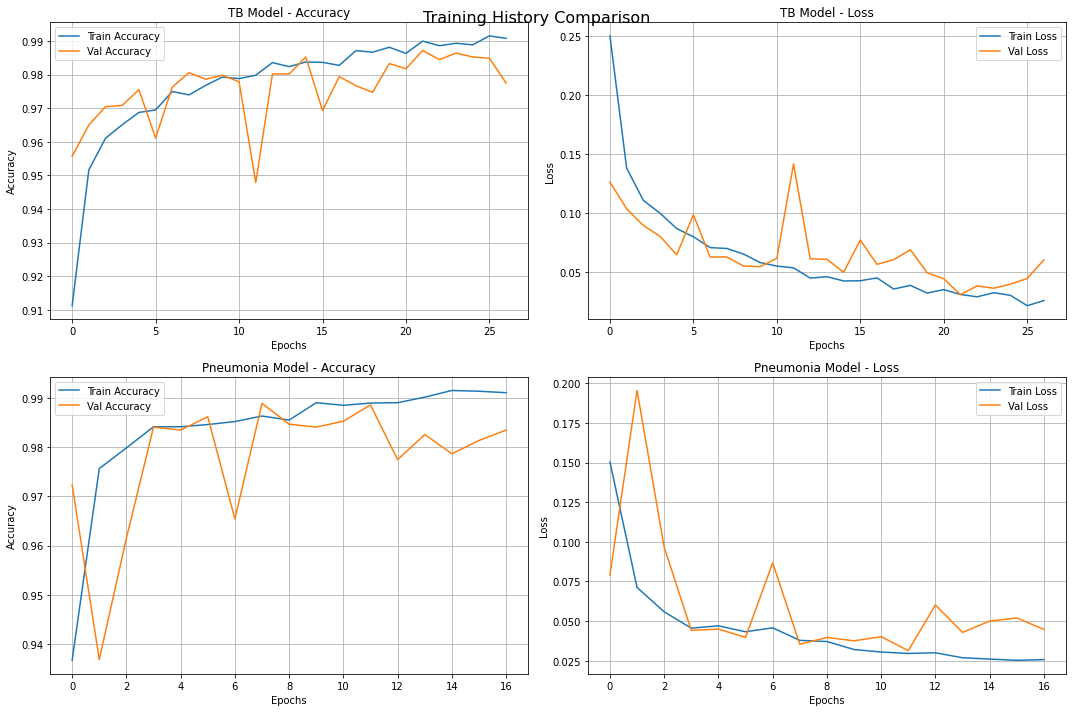


✅ Performance comparison completed!


In [11]:
import matplotlib.pyplot as plt

print("📊 COMPARING BOTH MODELS")
print("="*60)

# Compare final metrics
comparison_data = {
    'Model': ['TB Model', 'Pneumonia Model'],
    'Accuracy': [tb_test_acc, pneumonia_test_acc],
    'Precision': [tb_test_prec, pneumonia_test_prec],
    'Recall': [tb_test_rec, pneumonia_test_rec],
    'F1-Score': [
        2 * (tb_test_prec * tb_test_rec) / (tb_test_prec + tb_test_rec),
        2 * (pneumonia_test_prec * pneumonia_test_rec) / (pneumonia_test_prec + pneumonia_test_rec)
    ]
}

import pandas as pd
comparison_df = pd.DataFrame(comparison_data)
print("\n📋 Model Comparison:")
print(comparison_df.round(4))

# Plot training history
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Training History Comparison', fontsize=16)

# TB Model plots
axes[0, 0].plot(tb_history.history['accuracy'], label='Train Accuracy')
axes[0, 0].plot(tb_history.history['val_accuracy'], label='Val Accuracy')
axes[0, 0].set_title('TB Model - Accuracy')
axes[0, 0].set_xlabel('Epochs')
axes[0, 0].set_ylabel('Accuracy')
axes[0, 0].legend()
axes[0, 0].grid(True)

axes[0, 1].plot(tb_history.history['loss'], label='Train Loss')
axes[0, 1].plot(tb_history.history['val_loss'], label='Val Loss')
axes[0, 1].set_title('TB Model - Loss')
axes[0, 1].set_xlabel('Epochs')
axes[0, 1].set_ylabel('Loss')
axes[0, 1].legend()
axes[0, 1].grid(True)

# Pneumonia Model plots
axes[1, 0].plot(pneumonia_history.history['accuracy'], label='Train Accuracy')
axes[1, 0].plot(pneumonia_history.history['val_accuracy'], label='Val Accuracy')
axes[1, 0].set_title('Pneumonia Model - Accuracy')
axes[1, 0].set_xlabel('Epochs')
axes[1, 0].set_ylabel('Accuracy')
axes[1, 0].legend()
axes[1, 0].grid(True)

axes[1, 1].plot(pneumonia_history.history['loss'], label='Train Loss')
axes[1, 1].plot(pneumonia_history.history['val_loss'], label='Val Loss')
axes[1, 1].set_title('Pneumonia Model - Loss')
axes[1, 1].set_xlabel('Epochs')
axes[1, 1].set_ylabel('Loss')
axes[1, 1].legend()
axes[1, 1].grid(True)

plt.tight_layout()
plt.show()

print("\n✅ Performance comparison completed!")

In [12]:
def predict_with_binary_models(tb_model, pneumonia_model, img_path):
    """
    Use both models to make predictions
    - Each model gives a clear Normal vs Disease answer
    - Combine results intelligently
    
    Updated for new directory structure with shared normal dataset
    """
    
    # Preprocess image
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=(IMAGE_SIZE, IMAGE_SIZE))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0
    
    # Get predictions from both models
    tb_pred = tb_model.predict(img_array, verbose=0)[0]
    pneumonia_pred = pneumonia_model.predict(img_array, verbose=0)[0]
    
    # Extract probabilities (sigmoid output for binary classification)
    # Note: Since we're using binary classification with sigmoid, we get single probability
    tb_disease_prob = tb_pred[0] if len(tb_pred) == 1 else tb_pred[1]
    tb_normal_prob = 1 - tb_disease_prob
    
    pneumonia_disease_prob = pneumonia_pred[0] if len(pneumonia_pred) == 1 else pneumonia_pred[1]
    pneumonia_normal_prob = 1 - pneumonia_disease_prob
    
    print(f"=== BINARY MODEL PREDICTIONS ===")
    print(f"Image: {os.path.basename(img_path)}")
    print(f"\n🦠 TB Model:")
    print(f"  Normal: {tb_normal_prob:.1%}")
    print(f"  TB: {tb_disease_prob:.1%}")
    print(f"  → Prediction: {'🔴 TB DETECTED' if tb_disease_prob > 0.5 else '🟢 Normal'}")
    
    print(f"\n🫁 Pneumonia Model:")
    print(f"  Normal: {pneumonia_normal_prob:.1%}")
    print(f"  Pneumonia: {pneumonia_disease_prob:.1%}")
    print(f"  → Prediction: {'🟡 PNEUMONIA DETECTED' if pneumonia_disease_prob > 0.5 else '🟢 Normal'}")
    
    # Combined interpretation
    tb_detected = tb_disease_prob > 0.5
    pneumonia_detected = pneumonia_disease_prob > 0.5
    
    print(f"\n=== 🏥 FINAL MEDICAL DIAGNOSIS ===")
    if not tb_detected and not pneumonia_detected:
        print("✅ NORMAL CHEST X-RAY")
        print("   No significant pathology detected")
    elif tb_detected and not pneumonia_detected:
        print(f"🔴 TUBERCULOSIS DETECTED")
        print(f"   Confidence: {tb_disease_prob:.1%}")
        print("   Recommend: TB screening, sputum test")
    elif pneumonia_detected and not tb_detected:
        print(f"🟡 PNEUMONIA DETECTED")
        print(f"   Confidence: {pneumonia_disease_prob:.1%}")
        print("   Recommend: Antibiotic treatment consideration")
    else:
        print(f"🔴 MULTIPLE CONDITIONS DETECTED")
        print(f"   TB: {tb_disease_prob:.1%} | Pneumonia: {pneumonia_disease_prob:.1%}")
        print("   ⚠️  Possible co-infection - requires urgent medical review")
    
    return {
        'tb': {'normal': float(tb_normal_prob), 'disease': float(tb_disease_prob)},
        'pneumonia': {'normal': float(pneumonia_normal_prob), 'disease': float(pneumonia_disease_prob)}
    }

def test_models_on_samples(tb_model, pneumonia_model):
    """
    Test both models on sample images from the updated directory structure
    
    Updated paths:
    - shared_normal_dir: Contains all normal images
    - tb_dataset_dir: Contains TB disease images + symlinks to normal
    - pneumonia_dataset_dir: Contains pneumonia disease images + symlinks to normal
    """
    
    print("🧪 TESTING BINARY MODELS ON SAMPLE IMAGES")
    print("="*60)
    print(f"📁 Using updated directory structure:")
    print(f"   Shared Normal: {shared_normal_dir}")
    print(f"   TB Dataset: {tb_dataset_dir}")
    print(f"   Pneumonia Dataset: {pneumonia_dataset_dir}")
    
    # Test on Normal image (from shared normal dataset)
    try:
        normal_test_dir = os.path.join(shared_normal_dir, 'test', 'Normal')
        print(f"\n🔍 Looking for normal images in: {normal_test_dir}")
        
        if os.path.exists(normal_test_dir):
            normal_images = [f for f in os.listdir(normal_test_dir) 
                           if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
            if normal_images:
                normal_img_path = os.path.join(normal_test_dir, normal_images[0])
                print("\n" + "="*40)
                print("TESTING ON NORMAL X-RAY")
                print("="*40)
                predict_with_binary_models(tb_model, pneumonia_model, normal_img_path)
            else:
                print("❌ No normal images found in test directory")
        else:
            print(f"❌ Normal test directory does not exist: {normal_test_dir}")
    except Exception as e:
        print(f"❌ Could not test normal image: {e}")

    # Test on TB image
    try:
        tb_test_dir = os.path.join(tb_dataset_dir, 'test', 'Disease')
        print(f"\n🔍 Looking for TB images in: {tb_test_dir}")
        
        if os.path.exists(tb_test_dir):
            tb_images = [f for f in os.listdir(tb_test_dir) 
                        if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
            if tb_images:
                tb_img_path = os.path.join(tb_test_dir, tb_images[0])
                print("\n" + "="*40)
                print("TESTING ON TB X-RAY")
                print("="*40)
                predict_with_binary_models(tb_model, pneumonia_model, tb_img_path)
            else:
                print("❌ No TB images found in test directory")
        else:
            print(f"❌ TB test directory does not exist: {tb_test_dir}")
    except Exception as e:
        print(f"❌ Could not test TB image: {e}")

    # Test on Pneumonia image
    try:
        pneumonia_test_dir = os.path.join(pneumonia_dataset_dir, 'test', 'Disease')
        print(f"\n🔍 Looking for pneumonia images in: {pneumonia_test_dir}")
        
        if os.path.exists(pneumonia_test_dir):
            pneumonia_images = [f for f in os.listdir(pneumonia_test_dir) 
                              if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
            if pneumonia_images:
                pneumonia_img_path = os.path.join(pneumonia_test_dir, pneumonia_images[0])
                print("\n" + "="*40)
                print("TESTING ON PNEUMONIA X-RAY")
                print("="*40)
                predict_with_binary_models(tb_model, pneumonia_model, pneumonia_img_path)
            else:
                print("❌ No pneumonia images found in test directory")
        else:
            print(f"❌ Pneumonia test directory does not exist: {pneumonia_test_dir}")
    except Exception as e:
        print(f"❌ Could not test pneumonia image: {e}")

    print("\n✅ Prediction testing completed!")

def verify_directory_structure():
    """
    Verify that all directories exist and show their contents
    """
    print("\n🔍 VERIFYING DIRECTORY STRUCTURE")
    print("="*50)
    
    directories_to_check = [
        (shared_normal_dir, "Shared Normal Dataset"),
        (tb_dataset_dir, "TB Dataset"),
        (pneumonia_dataset_dir, "Pneumonia Dataset")
    ]
    
    for dir_path, dir_name in directories_to_check:
        print(f"\n📁 {dir_name}: {dir_path}")
        
        if os.path.exists(dir_path):
            print("   ✅ Directory exists")
            
            # Check subdirectories
            for split in ['train', 'val', 'test']:
                split_path = os.path.join(dir_path, split)
                if os.path.exists(split_path):
                    print(f"   📂 {split}/")
                    
                    # Check class folders
                    for class_folder in os.listdir(split_path):
                        class_path = os.path.join(split_path, class_folder)
                        if os.path.isdir(class_path):
                            # Count files
                            files = [f for f in os.listdir(class_path) 
                                   if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
                            
                            # Check if it's a symlink
                            symlink_info = " (symlink)" if os.path.islink(class_path) else ""
                            print(f"      📷 {class_folder}/: {len(files)} images{symlink_info}")
                else:
                    print(f"   ❌ {split}/ does not exist")
        else:
            print("   ❌ Directory does not exist")

# First verify the directory structure
# verify_directory_structure()

# Then run the tests (uncomment when models are trained)
test_models_on_samples(tb_model, pneumonia_model)

🧪 TESTING BINARY MODELS ON SAMPLE IMAGES
📁 Using updated directory structure:
   Shared Normal: /kaggle/working/shared_normal_dataset
   TB Dataset: /kaggle/working/tb_balanced_dataset
   Pneumonia Dataset: /kaggle/working/pneumonia_balanced_dataset

🔍 Looking for normal images in: /kaggle/working/shared_normal_dataset/test/Normal

TESTING ON NORMAL X-RAY
=== BINARY MODEL PREDICTIONS ===
Image: s1185.png

🦠 TB Model:
  Normal: 100.0%
  TB: 0.0%
  → Prediction: 🟢 Normal

🫁 Pneumonia Model:
  Normal: 100.0%
  Pneumonia: 0.0%
  → Prediction: 🟢 Normal

=== 🏥 FINAL MEDICAL DIAGNOSIS ===
✅ NORMAL CHEST X-RAY
   No significant pathology detected

🔍 Looking for TB images in: /kaggle/working/tb_balanced_dataset/test/Disease

TESTING ON TB X-RAY
=== BINARY MODEL PREDICTIONS ===
Image: tb0570.png

🦠 TB Model:
  Normal: 0.0%
  TB: 100.0%
  → Prediction: 🔴 TB DETECTED

🫁 Pneumonia Model:
  Normal: 100.0%
  Pneumonia: 0.0%
  → Prediction: 🟢 Normal

=== 🏥 FINAL MEDICAL DIAGNOSIS ===
🔴 TUBERCULOSIS DE

In [13]:
import tensorflowjs as tfjs
import json
import zipfile

def export_binary_model(model, model_name, disease_name, test_accuracy, test_precision, test_recall):
    """Export model to TFJS format with metadata"""
    
    print(f"\n📦 Exporting {disease_name} model...")
    
    # Create output directory
    output_dir = f"{model_name}_tfjs"
    os.makedirs(output_dir, exist_ok=True)
    
    # Convert to TFJS
    tfjs.converters.save_keras_model(model, output_dir)
    print(f"  ✅ TFJS conversion completed")
    
    # Create comprehensive metadata
    f1_score = 2 * (test_precision * test_recall) / (test_precision + test_recall)
    
    metadata = {
        "model_info": {
            "type": "binary_classification",
            "disease": disease_name,
            "version": "1.0",
            "input_shape": [IMAGE_SIZE, IMAGE_SIZE, 3],
            "num_classes": 2,
            "class_names": ["Normal", disease_name],
            "activation": "sigmoid",
            "confidence_threshold": 0.5,
            "architecture": "VGG16 + Custom Head"
        },
        "performance": {
            "test_accuracy": float(test_accuracy),
            "test_precision": float(test_precision),
            "test_recall": float(test_recall),
            "test_f1_score": float(f1_score)
        },
        "preprocessing": {
            "rescale": "1./255",
            "target_size": [IMAGE_SIZE, IMAGE_SIZE],
            "color_mode": "rgb"
        },
        "interpretation": {
            "class_0": "Normal",
            "class_1": disease_name,
           "decision_rule": ">= 0.5 is Disease, < 0.5 is Normal",
            "output_format": "single_probability_for_disease_class"
        },
        "usage": {
            "framework": "TensorFlow.js",
            "input_format": "normalized_rgb_image",
            "output_format": "[normal_probability, disease_probability]"
        }
    }
    
    # Save metadata
    metadata_path = os.path.join(output_dir, 'metadata.json')
    with open(metadata_path, 'w') as f:
        json.dump(metadata, f, indent=2)
    print(f"  ✅ Metadata saved")
    
    # Create ZIP file
    zip_filename = f"{model_name}.zip"
    with zipfile.ZipFile(zip_filename, 'w', zipfile.ZIP_DEFLATED) as zipf:
        for root, dirs, files in os.walk(output_dir):
            for file in files:
                file_path = os.path.join(root, file)
                arcname = os.path.relpath(file_path, output_dir)
                zipf.write(file_path, arcname)
    
    zip_size = os.path.getsize(zip_filename) / (1024 * 1024)  # Size in MB
    print(f"  ✅ ZIP created: {zip_filename} ({zip_size:.2f} MB)")
    
    return zip_filename

# Export both models
print("📦 EXPORTING MODELS TO TENSORFLOW.JS")
print("="*60)

# Export TB model
tb_zip = export_binary_model(
    tb_model, 
    "tuberculosis_binary", 
    "Tuberculosis",
    tb_test_acc,
    tb_test_prec, 
    tb_test_rec
)

# Export Pneumonia model  
pneumonia_zip = export_binary_model(
    pneumonia_model,
    "pneumonia_binary",
    "Pneumonia", 
    pneumonia_test_acc,
    pneumonia_test_prec,
    pneumonia_test_rec
)

print(f"\n🎉 EXPORT COMPLETED!")
print(f"📦 TB Model: {tb_zip}")
print(f"📦 Pneumonia Model: {pneumonia_zip}")

# Save weights separately (optional backup)
tb_model.save_weights("tuberculosis_binary_weights.h5")
pneumonia_model.save_weights("pneumonia_binary_weights.h5")
print(f"\n💾 Backup weights saved:")
print(f"  - tuberculosis_binary_weights.h5")
print(f"  - pneumonia_binary_weights.h5")

print(f"\n✅ ALL MODELS EXPORTED SUCCESSFULLY!")
print(f"🚀 Ready for deployment!")

📦 EXPORTING MODELS TO TENSORFLOW.JS

📦 Exporting Tuberculosis model...


/opt/conda/lib/python3.6/site-packages/tensorflowjs/converters/keras_h5_conversion.py:123: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  return h5py.File(h5file)


  ✅ TFJS conversion completed
  ✅ Metadata saved
  ✅ ZIP created: tuberculosis_binary.zip (52.70 MB)

📦 Exporting Pneumonia model...
  ✅ TFJS conversion completed
  ✅ Metadata saved
  ✅ ZIP created: pneumonia_binary.zip (52.72 MB)

🎉 EXPORT COMPLETED!
📦 TB Model: tuberculosis_binary.zip
📦 Pneumonia Model: pneumonia_binary.zip

💾 Backup weights saved:
  - tuberculosis_binary_weights.h5
  - pneumonia_binary_weights.h5

✅ ALL MODELS EXPORTED SUCCESSFULLY!
🚀 Ready for deployment!


In [14]:
print("🏆 FINAL PROJECT SUMMARY")
print("="*60)

print(f"\n📊 Model Performance Summary:")
print(f"┌─────────────────┬──────────┬───────────┬─────────┬─────────┐")
print(f"│ Model           │ Accuracy │ Precision │ Recall  │ F1-Score│")
print(f"├─────────────────┼──────────┼───────────┼─────────┼─────────┤")
print(f"│ TB Binary       │ {tb_test_acc:8.3f} │ {tb_test_prec:9.3f} │ {tb_test_rec:7.3f} │ {2 * (tb_test_prec * tb_test_rec) / (tb_test_prec + tb_test_rec):7.3f} │")
print(f"│ Pneumonia Binary│ {pneumonia_test_acc:8.3f} │ {pneumonia_test_prec:9.3f} │ {pneumonia_test_rec:7.3f} │ {2 * (pneumonia_test_prec * pneumonia_test_rec) / (pneumonia_test_prec + pneumonia_test_rec):7.3f} │")
print(f"└─────────────────┴──────────┴───────────┴─────────┴─────────┘")

print(f"\n📦 Exported Files:")
print(f"  🦠 {tb_zip}")
print(f"  🫁 {pneumonia_zip}")

print(f"\n🎯 Key Advantages of Binary Approach:")
print(f"  ✅ Each model specializes in one disease")
print(f"  ✅ Clear decision boundaries (Normal vs Disease)")
print(f"  ✅ No confusion between TB and Pneumonia")
print(f"  ✅ Can detect co-infections when both models trigger")
print(f"  ✅ Separate deployment flexibility")
print(f"  ✅ Better interpretability for medical professionals")

print(f"\n🔬 Medical Workflow:")
print(f"  1. Load chest X-ray")
print(f"  2. Run both models independently")
print(f"  3. Get clear Normal/Disease probabilities")
print(f"  4. Make clinical decision based on thresholds")
print(f"  5. Flag potential co-infections for review")

print(f"\n🚀 Next Steps:")
print(f"  1. Download the ZIP files")
print(f"  2. Deploy models to your web application")
print(f"  3. Implement the prediction logic")
print(f"  4. Set appropriate confidence thresholds")
print(f"  5. Add medical disclaimer and expert review workflow")

print(f"\n✨ PROJECT COMPLETED SUCCESSFULLY! ✨")

🏆 FINAL PROJECT SUMMARY

📊 Model Performance Summary:
┌─────────────────┬──────────┬───────────┬─────────┬─────────┐
│ Model           │ Accuracy │ Precision │ Recall  │ F1-Score│
├─────────────────┼──────────┼───────────┼─────────┼─────────┤
│ TB Binary       │    0.986 │     0.955 │   0.957 │   0.956 │
│ Pneumonia Binary│    0.988 │     0.988 │   0.979 │   0.983 │
└─────────────────┴──────────┴───────────┴─────────┴─────────┘

📦 Exported Files:
  🦠 tuberculosis_binary.zip
  🫁 pneumonia_binary.zip

🎯 Key Advantages of Binary Approach:
  ✅ Each model specializes in one disease
  ✅ Clear decision boundaries (Normal vs Disease)
  ✅ No confusion between TB and Pneumonia
  ✅ Can detect co-infections when both models trigger
  ✅ Separate deployment flexibility
  ✅ Better interpretability for medical professionals

🔬 Medical Workflow:
  1. Load chest X-ray
  2. Run both models independently
  3. Get clear Normal/Disease probabilities
  4. Make clinical decision based on thresholds
  5. Flag 